In [1]:
from src.model import VAE
from src.trainer import SimCLRTrainer
from src.losses import accurary
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset


from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
majority = list(filter(lambda elem: elem[1] != 5, mnist)) # not 5
minority = list(filter(lambda elem: elem[1] == 5, mnist)) # 5

In [6]:
torch.manual_seed(101)

In [7]:
from src.utils import CMNISTGenerator, CMNIST, random_style_distribution

cmnist_generator = CMNISTGenerator(
    majority, # assign rich styles to non-5 digits
    random_style_distribution(),
)


In [8]:
cmnist = CMNIST(
    cmnist_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 54579/54579 [00:09<00:00, 6013.02item/s]


In [9]:
train_5, test_5 = random_split(minority, [2500, len(minority) - 2500])
train_5_generator = CMNISTGenerator(
    train_5,
    {
        corruptions.identity: 0.0,
        corruptions.stripe: 0.4,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.3,
    },
)
train_5 = CMNIST(
    train_5_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

Generating dataset: 100%|██████████| 2500/2500 [00:00<00:00, 5037.81item/s]


In [10]:
train = ConcatDataset([cmnist, train_5])
# train = train_5
train_size = int(0.8 * len(train))
train, valid = random_split(train, [train_size, len(train) - train_size])

In [11]:
test_5_generator = CMNISTGenerator(
    test_5,
    {
        corruptions.identity: 1.0,
        corruptions.stripe: 0.0,
        corruptions.zigzag: 0.0,
        corruptions.canny_edges: 0.0,
    },
)
test_5 = CMNIST(
    test_5_generator, 
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

Generating dataset: 100%|██████████| 2921/2921 [00:00<00:00, 49516.07item/s]


In [12]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test_5, batch_size=128, shuffle=False)

### CNN classifier

In [13]:
from src.model import SimpleCNNClassifier
from src.trainer import SimpleCNNTrainer

cnn = SimpleCNNClassifier(n_class=10).to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()
trainer = SimpleCNNTrainer(cnn, optimizer, criterion, 5, device)

In [14]:
trainer.fit(26, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 90/90 [00:00<00:00, 498.32it/s]


val_acc=0.916


val-epoch 5: 100%|██████████| 90/90 [00:00<00:00, 496.25it/s]


val_acc=0.974


val-epoch 10: 100%|██████████| 90/90 [00:00<00:00, 529.81it/s]


val_acc=0.979


val-epoch 15: 100%|██████████| 90/90 [00:00<00:00, 521.00it/s]


val_acc=0.980


val-epoch 20: 100%|██████████| 90/90 [00:00<00:00, 478.72it/s]


val_acc=0.980


val-epoch 25: 100%|██████████| 90/90 [00:00<00:00, 494.35it/s]

val_acc=0.979


In [15]:
trainer._valid(test_loader, True, epoch_id=0)

val-epoch 0: 100%|██████████| 23/23 [00:00<00:00, 471.31it/s]

val_acc=0.955


### CD-VAE zero-shot

In [32]:
vae = VAE(total_z_dim=32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": 0.1, "beta": 1.0, "alpha": [200, 50]},
    verbose_period=5,
    device=device,
)

In [33]:
trainer.fit(31, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 90/90 [00:00<00:00, 231.90it/s]


val_vae_loss=80.491, val_c_loss=0.200, val_s_loss=-3.059


val-epoch 5: 100%|██████████| 90/90 [00:00<00:00, 232.57it/s]


val_vae_loss=49.139, val_c_loss=0.098, val_s_loss=-4.028


val-epoch 10: 100%|██████████| 90/90 [00:00<00:00, 220.60it/s]


val_vae_loss=39.275, val_c_loss=0.083, val_s_loss=-4.449


val-epoch 15: 100%|██████████| 90/90 [00:00<00:00, 222.61it/s]


val_vae_loss=34.487, val_c_loss=0.077, val_s_loss=-4.521


val-epoch 20: 100%|██████████| 90/90 [00:00<00:00, 233.24it/s]


val_vae_loss=31.486, val_c_loss=0.071, val_s_loss=-4.564


val-epoch 25: 100%|██████████| 90/90 [00:00<00:00, 223.45it/s]


val_vae_loss=29.577, val_c_loss=0.072, val_s_loss=-4.564


val-epoch 30: 100%|██████████| 90/90 [00:00<00:00, 204.99it/s]

val_vae_loss=28.460, val_c_loss=0.066, val_s_loss=-4.588


In [34]:
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [35]:
mu_cs = []
mu_ss = []
labels = []
styles = []
datasource = []
with torch.no_grad():
    for X, label, style in tqdm(valid_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.zeros_like(label).cpu())
    for X, label, style in tqdm(test_loader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)
        datasource.append(torch.ones_like(label).cpu())


100%|██████████| 23/23 [00:00<00:00, 439.45it/s]


In [36]:
mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)
datasource = torch.cat(datasource, dim=0)

In [37]:
labels[torch.where(datasource == 0)[0]].bincount()

tensor([1193, 1361, 1119, 1256, 1195,  497, 1166, 1265, 1139, 1225],
       device='cuda:0')

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

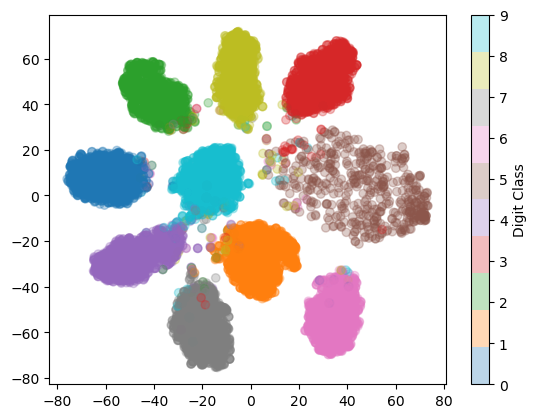

In [39]:
from_valid = torch.where(datasource == 0)[0]
plt.scatter(mu_cs_tsne[from_valid, 0], mu_cs_tsne[from_valid, 1], alpha=0.3, 
            c=labels.cpu()[from_valid].numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

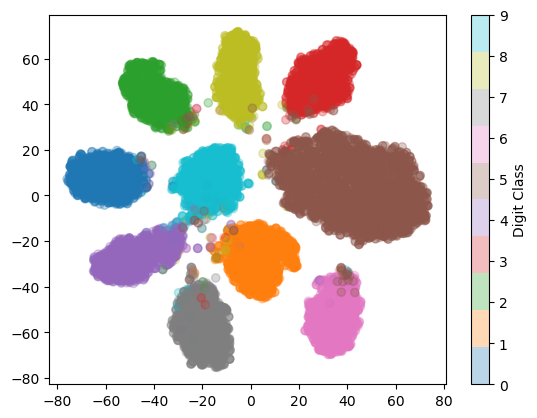

In [40]:
from_valid = torch.where(datasource == 0)
plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

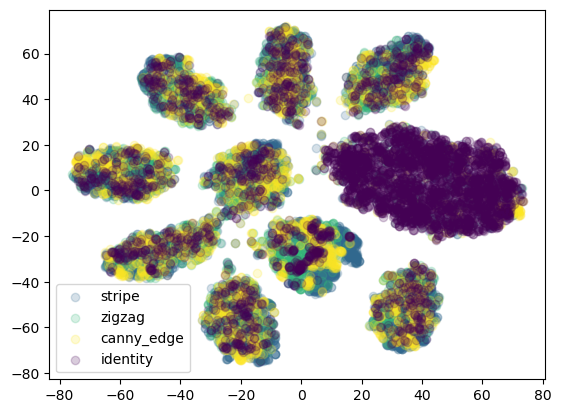

In [41]:
import numpy as np

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]

fig, ax = plt.subplots()
for g in [1,2,3,0]:
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [43]:
model = torch.nn.Sequential(
    torch.nn.Linear(16, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

In [44]:
EPOCHS = 26
VERBOSE_PERIOD = 5

for epoch in range(EPOCHS):
    verbose = (epoch % VERBOSE_PERIOD) == 0
    model.train()
    with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
        bar.set_description(f"epoch {epoch}")
        for X_batch, y_batch, _ in bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            mu_c, logvar_c = vae.encode(X_batch)[:2]
            logits = model(mu_c)
            # logits = model(torch.cat([mu_c, logvar_c], dim=1))
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            # update running stats
            acc = accurary(logits, y_batch)
            bar.set_postfix(loss=float(loss), acc=float(acc))
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for X_batch, y_batch, _ in tqdm(valid_loader, disable=not verbose):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            mu_c, logvar_c = vae.encode(X_batch)[:2]
            logits = model(mu_c)
            # logits = model(torch.cat([mu_c, logvar_c], dim=1))
            acc = accurary(logits, y_batch)
            total_acc += acc.item()
    if verbose:
        print("val_acc={:.3f}".format(total_acc / len(valid_loader)))
    
            


100%|██████████| 90/90 [00:00<00:00, 439.03it/s]


val_acc=0.983


100%|██████████| 90/90 [00:00<00:00, 428.50it/s]


val_acc=0.983


100%|██████████| 90/90 [00:00<00:00, 467.15it/s]


val_acc=0.984


100%|██████████| 90/90 [00:00<00:00, 461.68it/s]


val_acc=0.984


100%|██████████| 90/90 [00:00<00:00, 411.04it/s]


val_acc=0.984


100%|██████████| 90/90 [00:00<00:00, 483.86it/s]

val_acc=0.984


In [45]:
model.eval()
total_acc = 0
with torch.no_grad():
    for X_batch, y_batch, _ in tqdm(test_loader, disable=not verbose):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mu_c, logvar_c = vae.encode(X_batch)[:2]
        logits = model(mu_c)
        # logits = model(torch.cat([mu_c, logvar_c], dim=1))
        acc = accurary(logits, y_batch)
        total_acc += acc.item()
if verbose:
    print("val_acc={:.3f}".format(total_acc / len(test_loader)))

100%|██████████| 23/23 [00:00<00:00, 374.07it/s]

val_acc=0.962
